# Perbandingan Kecepatan Enkripsi Algoritma DES, TripleDES, AES, Blowfish

In [5]:
!pip install pycryptodome

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.1 MB/s eta 0:00:00


In [6]:
from Crypto.Util.Padding import pad, unpad
from Crypto.Random import get_random_bytes
from Crypto.Cipher import DES, DES3, AES, Blowfish
import time

## 1. Inisiasi dan Persiapan

In [13]:
# --- Konfigurasi Uji ---
NUM_ITERATIONS = 20
DATA_SIZES_MB = [0.5, 1, 5, 10, 20]

# Pemetaan Algoritma ke Ukuran Kunci (Bytes)
algorithm_map = {
    'DES': (DES, 8),
    '3DES': (DES3, 24), # 168-bit
    'AES-256': (AES, 32), # 256-bit
    'Blowfish-128': (Blowfish, 16)
}

## 2. Membuat Fungsi untuk mengukur waktu Enkripsi dan Dekripsi

In [20]:
def measure_time(cipher_module, key_size, data_block, is_encryption=True, iterations=10):
    iteration_times = []

    # 1. Padding Data: Data harus di-padding
    padded_data = pad(data_block, cipher_module.block_size)

    # 2. Generasi Kunci: Hasilkan kunci unik
    if cipher_module == DES3:
        key = DES3.adjust_key_parity(get_random_bytes(key_size))
    else:
        key = get_random_bytes(key_size)

    for _ in range(iterations):
        # 3. IV: Hasilkan IV baru untuk setiap iterasi (penting untuk MODE_CBC)
        iv = get_random_bytes(cipher_module.block_size)

        # Inisialisasi Cipher
        cipher = cipher_module.new(key, cipher_module.MODE_CBC, iv=iv)

        # --- BLOK PENGUKURAN WAKTU DIPINDAHKAN KE LUAR IF/ELSE ---

        start_time = time.time()

        if is_encryption:
          # Enkripsi: Simpan ciphertext yang dihasilkan untuk menjaga alur (meskipun tidak digunakan di sini)
          ciphertext = cipher.encrypt(padded_data)
        else:
          # Dekripsi: Membutuhkan ciphertext dari langkah enkripsi.
          # Untuk tujuan simulasi waktu, kita tetap menggunakan padded_data sebagai input dummy
          cipher.decrypt(padded_data)

        end_time = time.time()

        # WAKTU SELALU DIREKAM SETELAH OPERASI SELESAI
        iteration_times.append(end_time - start_time)

    return iteration_times # Mereturn list semua waktu

## 3. Menghitung Waktu rata-rata dan throughput

In [36]:
results = []

print("Memulai Simulasi Kinerja (Enkripsi)...")

for algo_name, (module, key_size) in algorithm_map.items():
    print(f"\n--- Menguji {algo_name} ---")

    for size_mb in DATA_SIZES_MB:
        # 1. Siapkan blok data acak untuk ukuran saat ini
        data_block = get_random_bytes(int(size_mb * 1024 * 1024))

        # 2. Ukur waktu rata-rata enkripsi
        enc_time = measure_time(
            module,
            key_size,
            data_block,
            is_encryption=True,
            iterations=NUM_ITERATIONS
        )

        # 3. Hitung Throughput
        #
        avg_enc_time = sum(enc_time)/NUM_ITERATIONS
        throughput = size_mb / avg_enc_time

        # 4. Simpan hasil
        results.append({
            'Algoritma': algo_name,
            'Ukuran Data (MB)': size_mb,
            'Waktu' : enc_time,
            'Waktu Rata-Rata (s)': avg_enc_time,
            'Throughput (MB/s)': throughput
        })
        print(f"  {size_mb} MB: {avg_enc_time:.4f} s | {enc_time} | {throughput:.2f} MB/s")

Memulai Simulasi Kinerja (Enkripsi)...

--- Menguji DES ---
  0.5 MB: 0.0088 s | [0.009659051895141602, 0.008726119995117188, 0.008913516998291016, 0.008646965026855469, 0.008682012557983398, 0.008751153945922852, 0.008850574493408203, 0.00867152214050293, 0.008971214294433594, 0.009058713912963867, 0.008677959442138672, 0.008701086044311523, 0.008654594421386719, 0.008793830871582031, 0.008618593215942383, 0.008713245391845703, 0.008837699890136719, 0.008629560470581055, 0.008619546890258789, 0.008644580841064453] | 56.88 MB/s
  1 MB: 0.0175 s | [0.017910242080688477, 0.018206357955932617, 0.017409324645996094, 0.0174100399017334, 0.01730799674987793, 0.01735544204711914, 0.01755809783935547, 0.018272876739501953, 0.017774105072021484, 0.01748061180114746, 0.017362117767333984, 0.017384767532348633, 0.017573833465576172, 0.01739668846130371, 0.017435550689697266, 0.017206668853759766, 0.017332792282104492, 0.017246246337890625, 0.01773548126220703, 0.017432689666748047] | 57.01 MB/s
 

## 4. Visualisasi Data

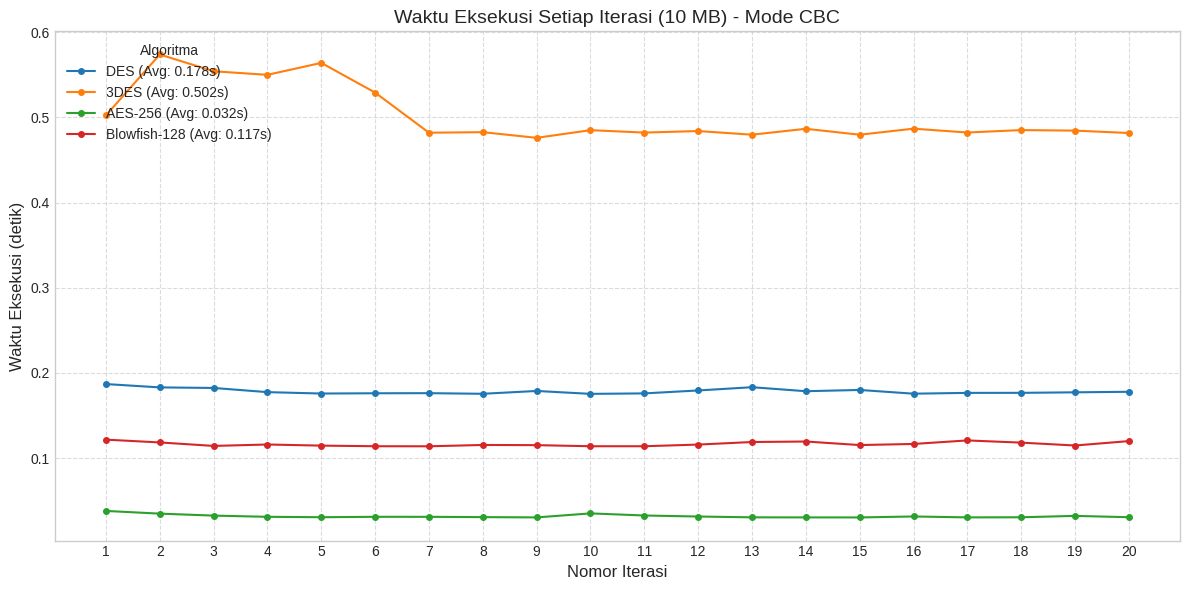

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Pilih data untuk ukuran 20 MB (terbesar untuk visualisasi yang jelas)
target_size = 10
plotting_data = {}

for entry in results:
    if entry['Ukuran Data (MB)'] == target_size:
        plotting_data[entry['Algoritma']] = entry['Waktu']

# Buat list untuk sumbu X (Iterasi 1 sampai 20)
iterations = np.arange(1, 21)

# Atur plotting
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-whitegrid')

# Plot data untuk setiap algoritma
for algo, times in plotting_data.items():
    plt.plot(iterations, times, marker='o', linestyle='-', markersize=4, label=f'{algo} (Avg: {np.mean(times):.3f}s)')

plt.title(f'Waktu Eksekusi Setiap Iterasi ({target_size} MB) - Mode CBC', fontsize=14)
plt.xlabel('Nomor Iterasi', fontsize=12)
plt.ylabel('Waktu Eksekusi (detik)', fontsize=12)
plt.xticks(iterations) # Pastikan sumbu X menampilkan semua iterasi
plt.legend(title="Algoritma", loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Simpan Grafik
graph_filename = f'iterasi_vs_waktu_{target_size}MB.png'
plt.savefig(graph_filename)
